## Feature Selection Methods: 

This notebook is experimenting 9 feature selection methods for Math subject Learning Loss, and yielding csv for the result as Feature_Selection_Math_Results.csv and importance_math.csv
- Filter methods:
    - Variance Threshold
- Embedded methods:
    - L1 Regularization (Lasso)
    - Random Forest Feature Importance 
- Wrapper methods:
    - Permutation Importance
        - with Random Forest
        - with Ridge Regression
    - Recursive Feature Elimination (RFE)
        - with Random Forest
        - with Ridge Regression
    - Sequential Feature Selection (SFS)
        - with KNN
        - with Ridge Regression

Then, it is comparing regression coefficients, and creating coef_math.csv
- L1 Regularization (Lasso) 
- L2 Regularization (Ridge)
- ElasticNet

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings 
# warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

**Loading Data**

Cleaned and integrated from [Data_Integration.ipynb](Data_Integration.ipynb)

In [3]:
df = pd.read_csv('DATA_Texas_District_v5.csv', sep=',', header=0)
print(df.shape)

(979, 126)


**Get dummies for categorical feature `Locale`**

In [4]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(979, 137)


**Split data**

In [5]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']

cols_drop = ['% Students Tested Reading - Grade 3 2018-2019',
            '% Students Tested Reading - Grade 4 2018-2019',
            '% Students Tested Reading - Grade 5 2018-2019',
            '% Students Tested Reading - Grade 6 2018-2019',
            '% Students Tested Reading - Grade 7 2018-2019',
            '% Students Tested Reading - Grade 8 2018-2019',
            '% Students Tested Reading - Grade 3 2020-2021',
            '% Students Tested Reading - Grade 4 2020-2021',
            '% Students Tested Reading - Grade 5 2020-2021',
            '% Students Tested Reading - Grade 6 2020-2021',
            '% Students Tested Reading - Grade 7 2020-2021',
            '% Students Tested Reading - Grade 8 2020-2021',
            'Average Score Reading All Grade 3 2018-2019',
            'Average Score Reading All Grade 4 2018-2019',
            'Average Score Reading All Grade 5 2018-2019',
            'Average Score Reading All Grade 6 2018-2019',
            'Average Score Reading All Grade 7 2018-2019',
            'Average Score Reading All Grade 8 2018-2019',
            'District #', 'County #']

y = df['Label_Math'].values
X = df.drop(columns=labels + cols_drop).values
columns = df.drop(columns=labels + cols_drop).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=123, shuffle=True)
print(X.shape)

(979, 114)


**Normalization**

In [6]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
random_state=123
results = pd.DataFrame()
results_coef = pd.DataFrame()

## 9 Feature Selection Methods

### Variance Threshold ###

In [8]:
from sklearn.feature_selection import VarianceThreshold

# dropping columns where 1-threshold of the values are similar
# a feature contains only 0s 80% of the time or only 1s 80% of the time
sel = VarianceThreshold(threshold=.8*(1-.8))

sel.fit_transform(X)
selected_var = columns[sel.get_support()]

temp = pd.DataFrame({'feature': columns,
                     'method': 'Variance Threshold',
                     'model': 'N/A',
                     'score': [1 if ft in selected_var else 0 for ft in columns],
                     'score_type': 'N/A'})
results = pd.concat([results, temp], ignore_index=True)

print('n_features_selected:',selected_var.shape[0])
print('Features Selected: ', selected_var)

n_features_selected: 13
Features Selected:  Index(['Total Students 2018-2019', 'Total Students 2020-2021', 'Median Age 10',
       'Median Age Male 10', 'Median Age Female 10', '# of Households 10',
       'Avg Household Size 10', '# of Families 10', 'Avg Family Size 10',
       '# of Housing Units 10', 'County Population', 'CARES ESSER I 20',
       'Locale_42-Rural: Distant'],
      dtype='object')


### L1(Lasso) Regularization ###

In [9]:
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, multi_class='ovr', random_state=random_state)
lasso.fit(X_train, y_train)

print('Train Accuracy: {:0.2f}'.format(lasso.score(X_train, y_train)))
print('Test Accuracy: {:0.2f}'.format(lasso.score(X_test, y_test)))

df_lasso = pd.DataFrame()

for c, cla in zip(lasso.coef_, ['Loss', 'Expected', 'Gain']):
    temp = pd.DataFrame({'feature': columns, 'model': 'Lasso', 'coef': c, 'label': cla})
    df_lasso = pd.concat([df_lasso, temp], ignore_index=True)
    
results_coef = pd.concat([results_coef, df_lasso], ignore_index=True)
df_lasso2 = df_lasso[df_lasso['label']=="Expected"]

temp = pd.DataFrame({'feature': df_lasso2['feature'], 
                        'method': 'Regularization',
                        'model': 'Lasso', 
                        'score': df_lasso2['coef'],
                        'score_type': 'N/A'})
results = pd.concat([results, temp], ignore_index=True)

Train Accuracy: 0.69
Test Accuracy: 0.63


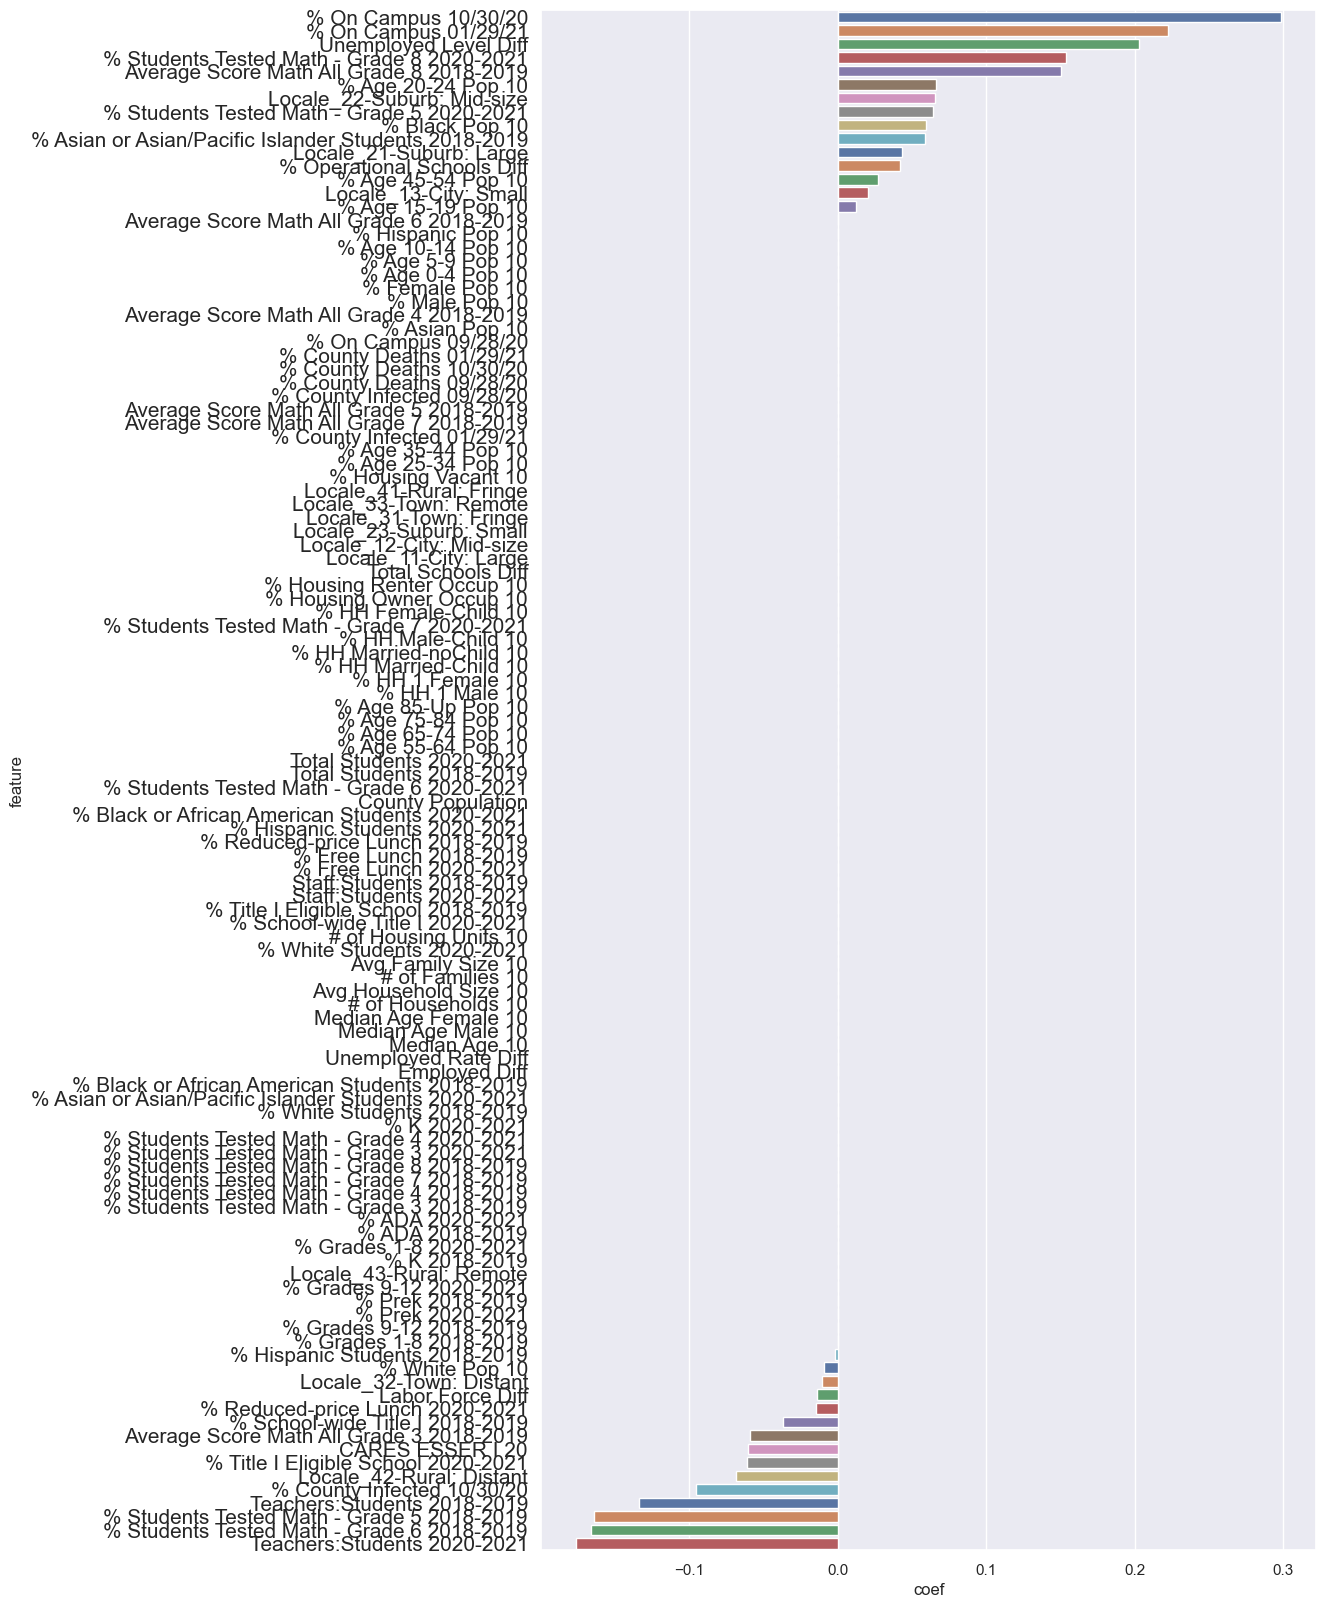

In [10]:
df_lasso2 = df_lasso2.sort_values(by=['coef'], ascending=False)
sns.set(rc={'figure.figsize':(10, 20)})
g=sns.barplot(data=df_lasso2, y="feature", x="coef", palette="deep", orient="h")
# g.set_xticklabels(g.get_xticklabels(), rotation=90, size=20)
g.set_yticklabels(g.get_yticklabels(), size=15)
plt.show()

### Random Forest Feature Importance ###

Train Score: 1.00
Test Score: 0.68


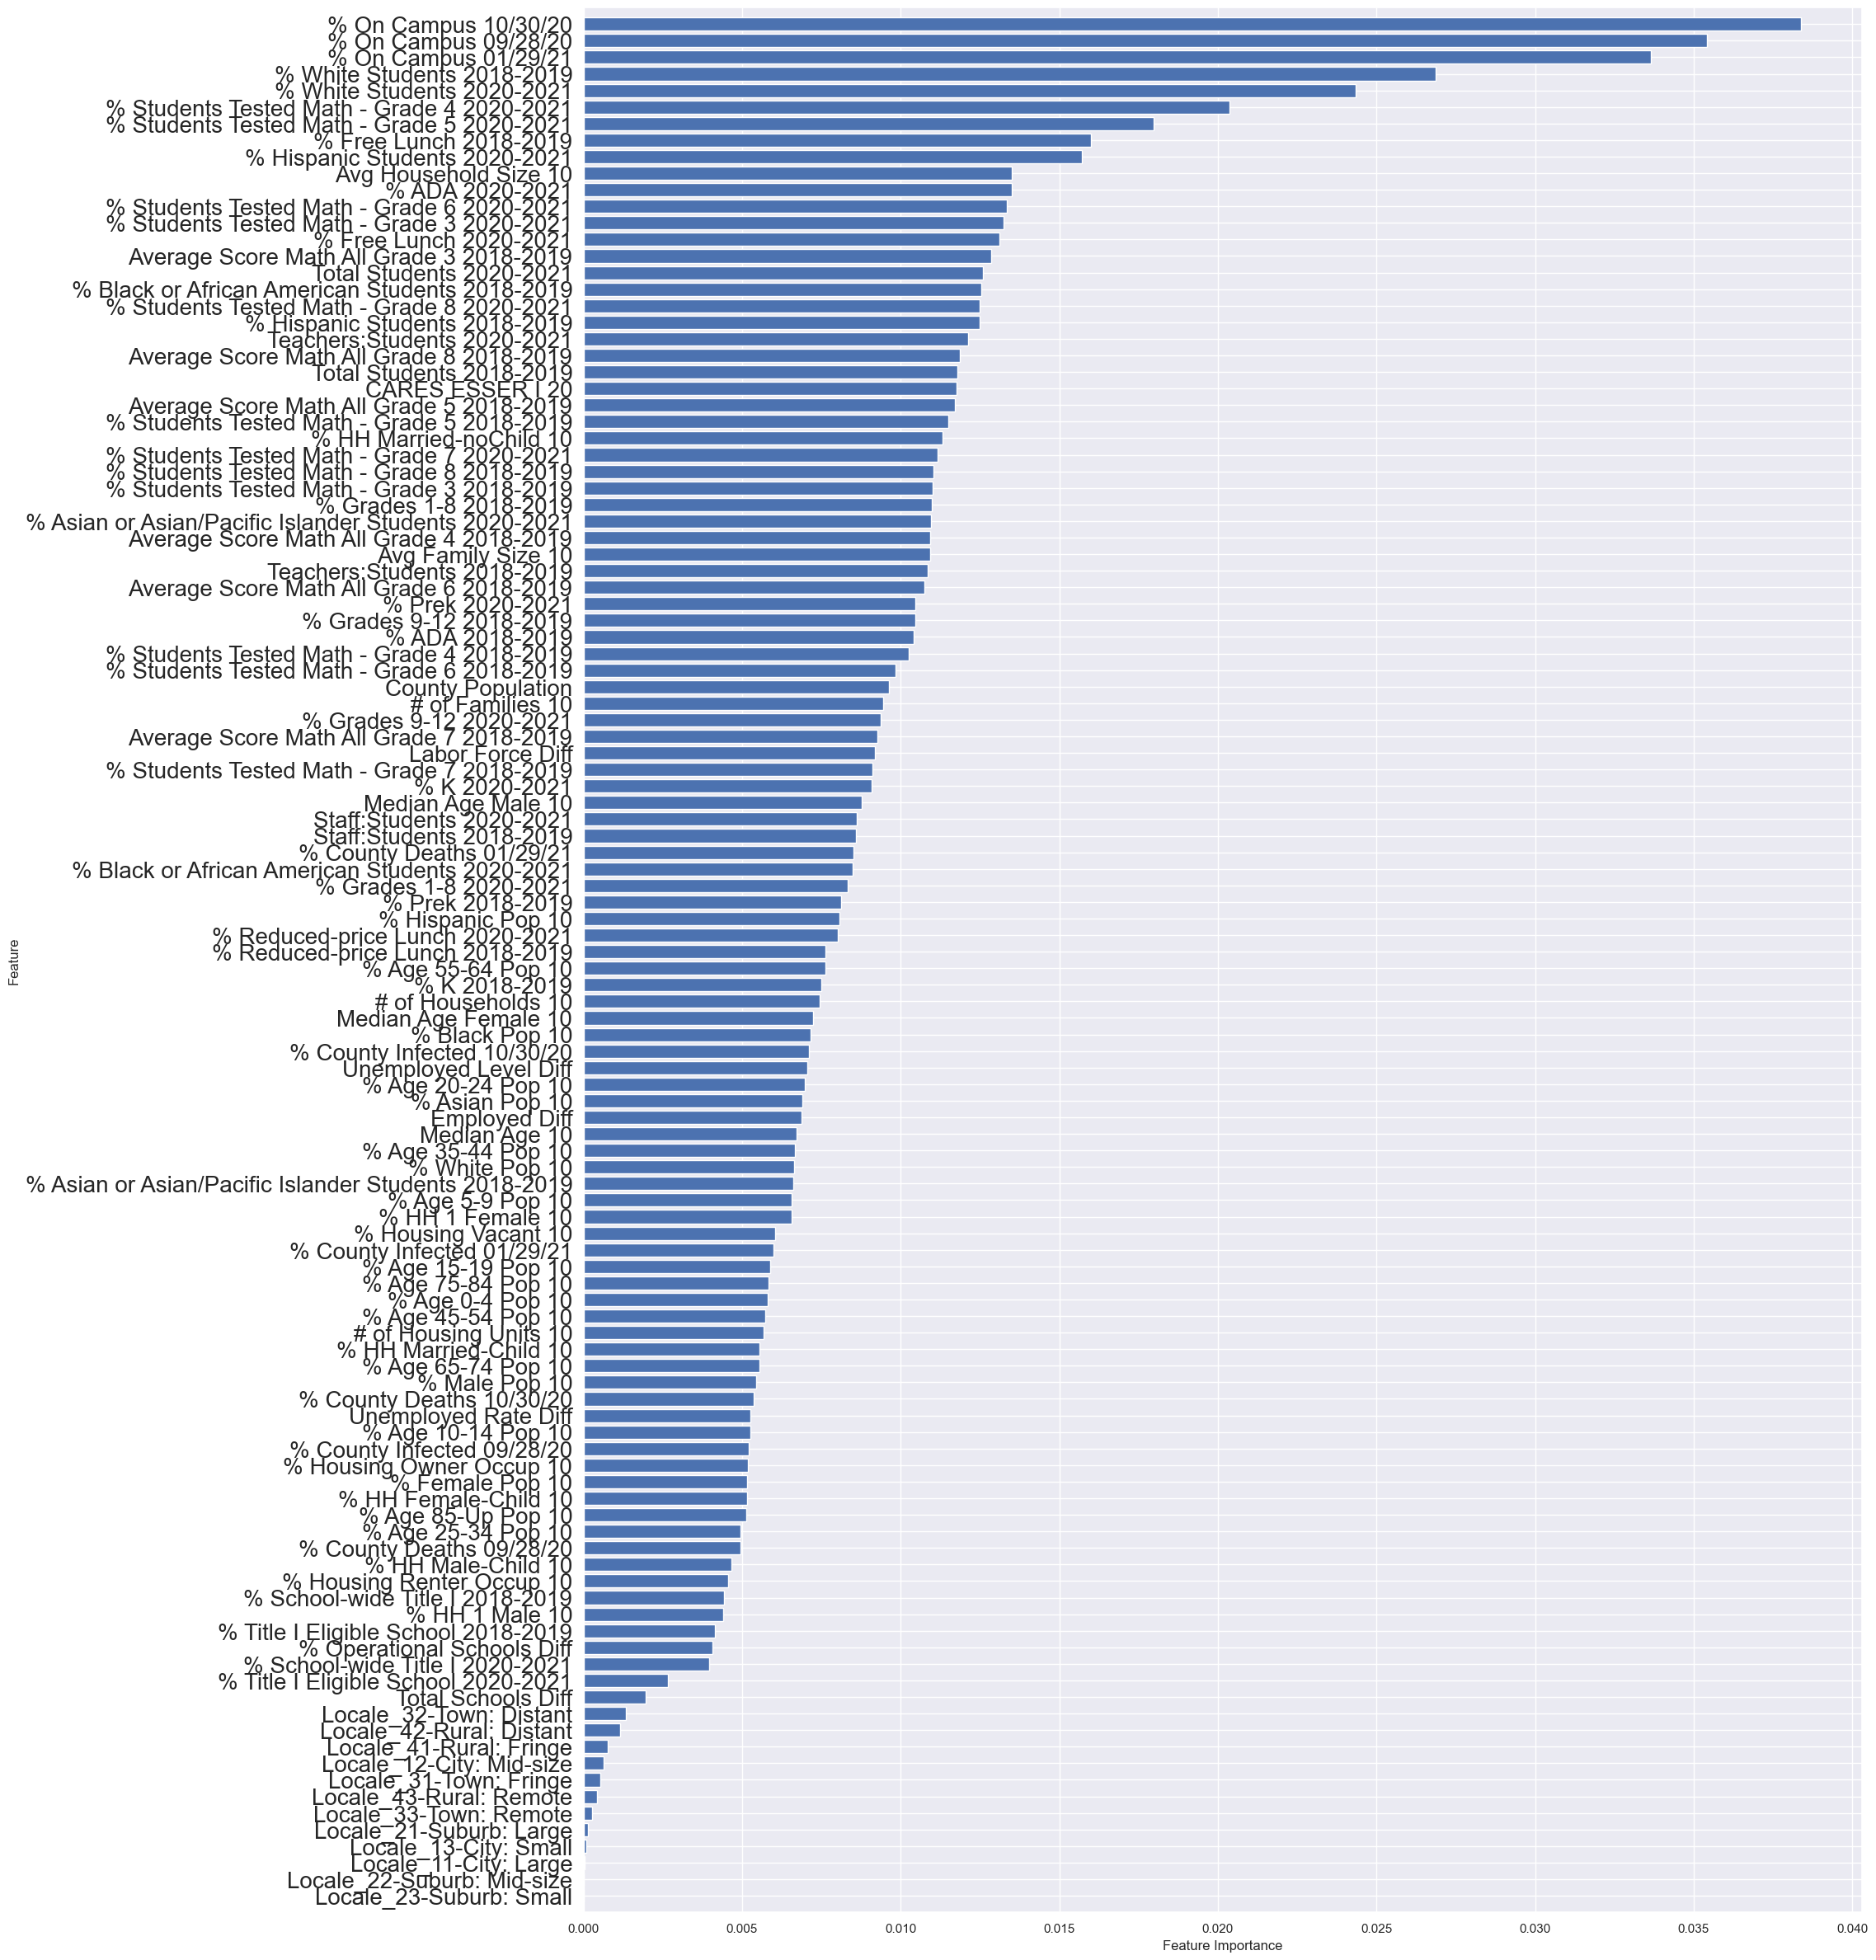

In [11]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,30))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.show()

temp = pd.DataFrame({'feature': columns, 
                        'method': 'Feature Importance',
                        'model': 'Random Forest', 
                        'score': importances,
                        'score_type': 'importances'})
results = pd.concat([results, temp], ignore_index=True)

### Permutation Importance ###
with Random Forest

Train Score: 1.00
Test Score: 0.68


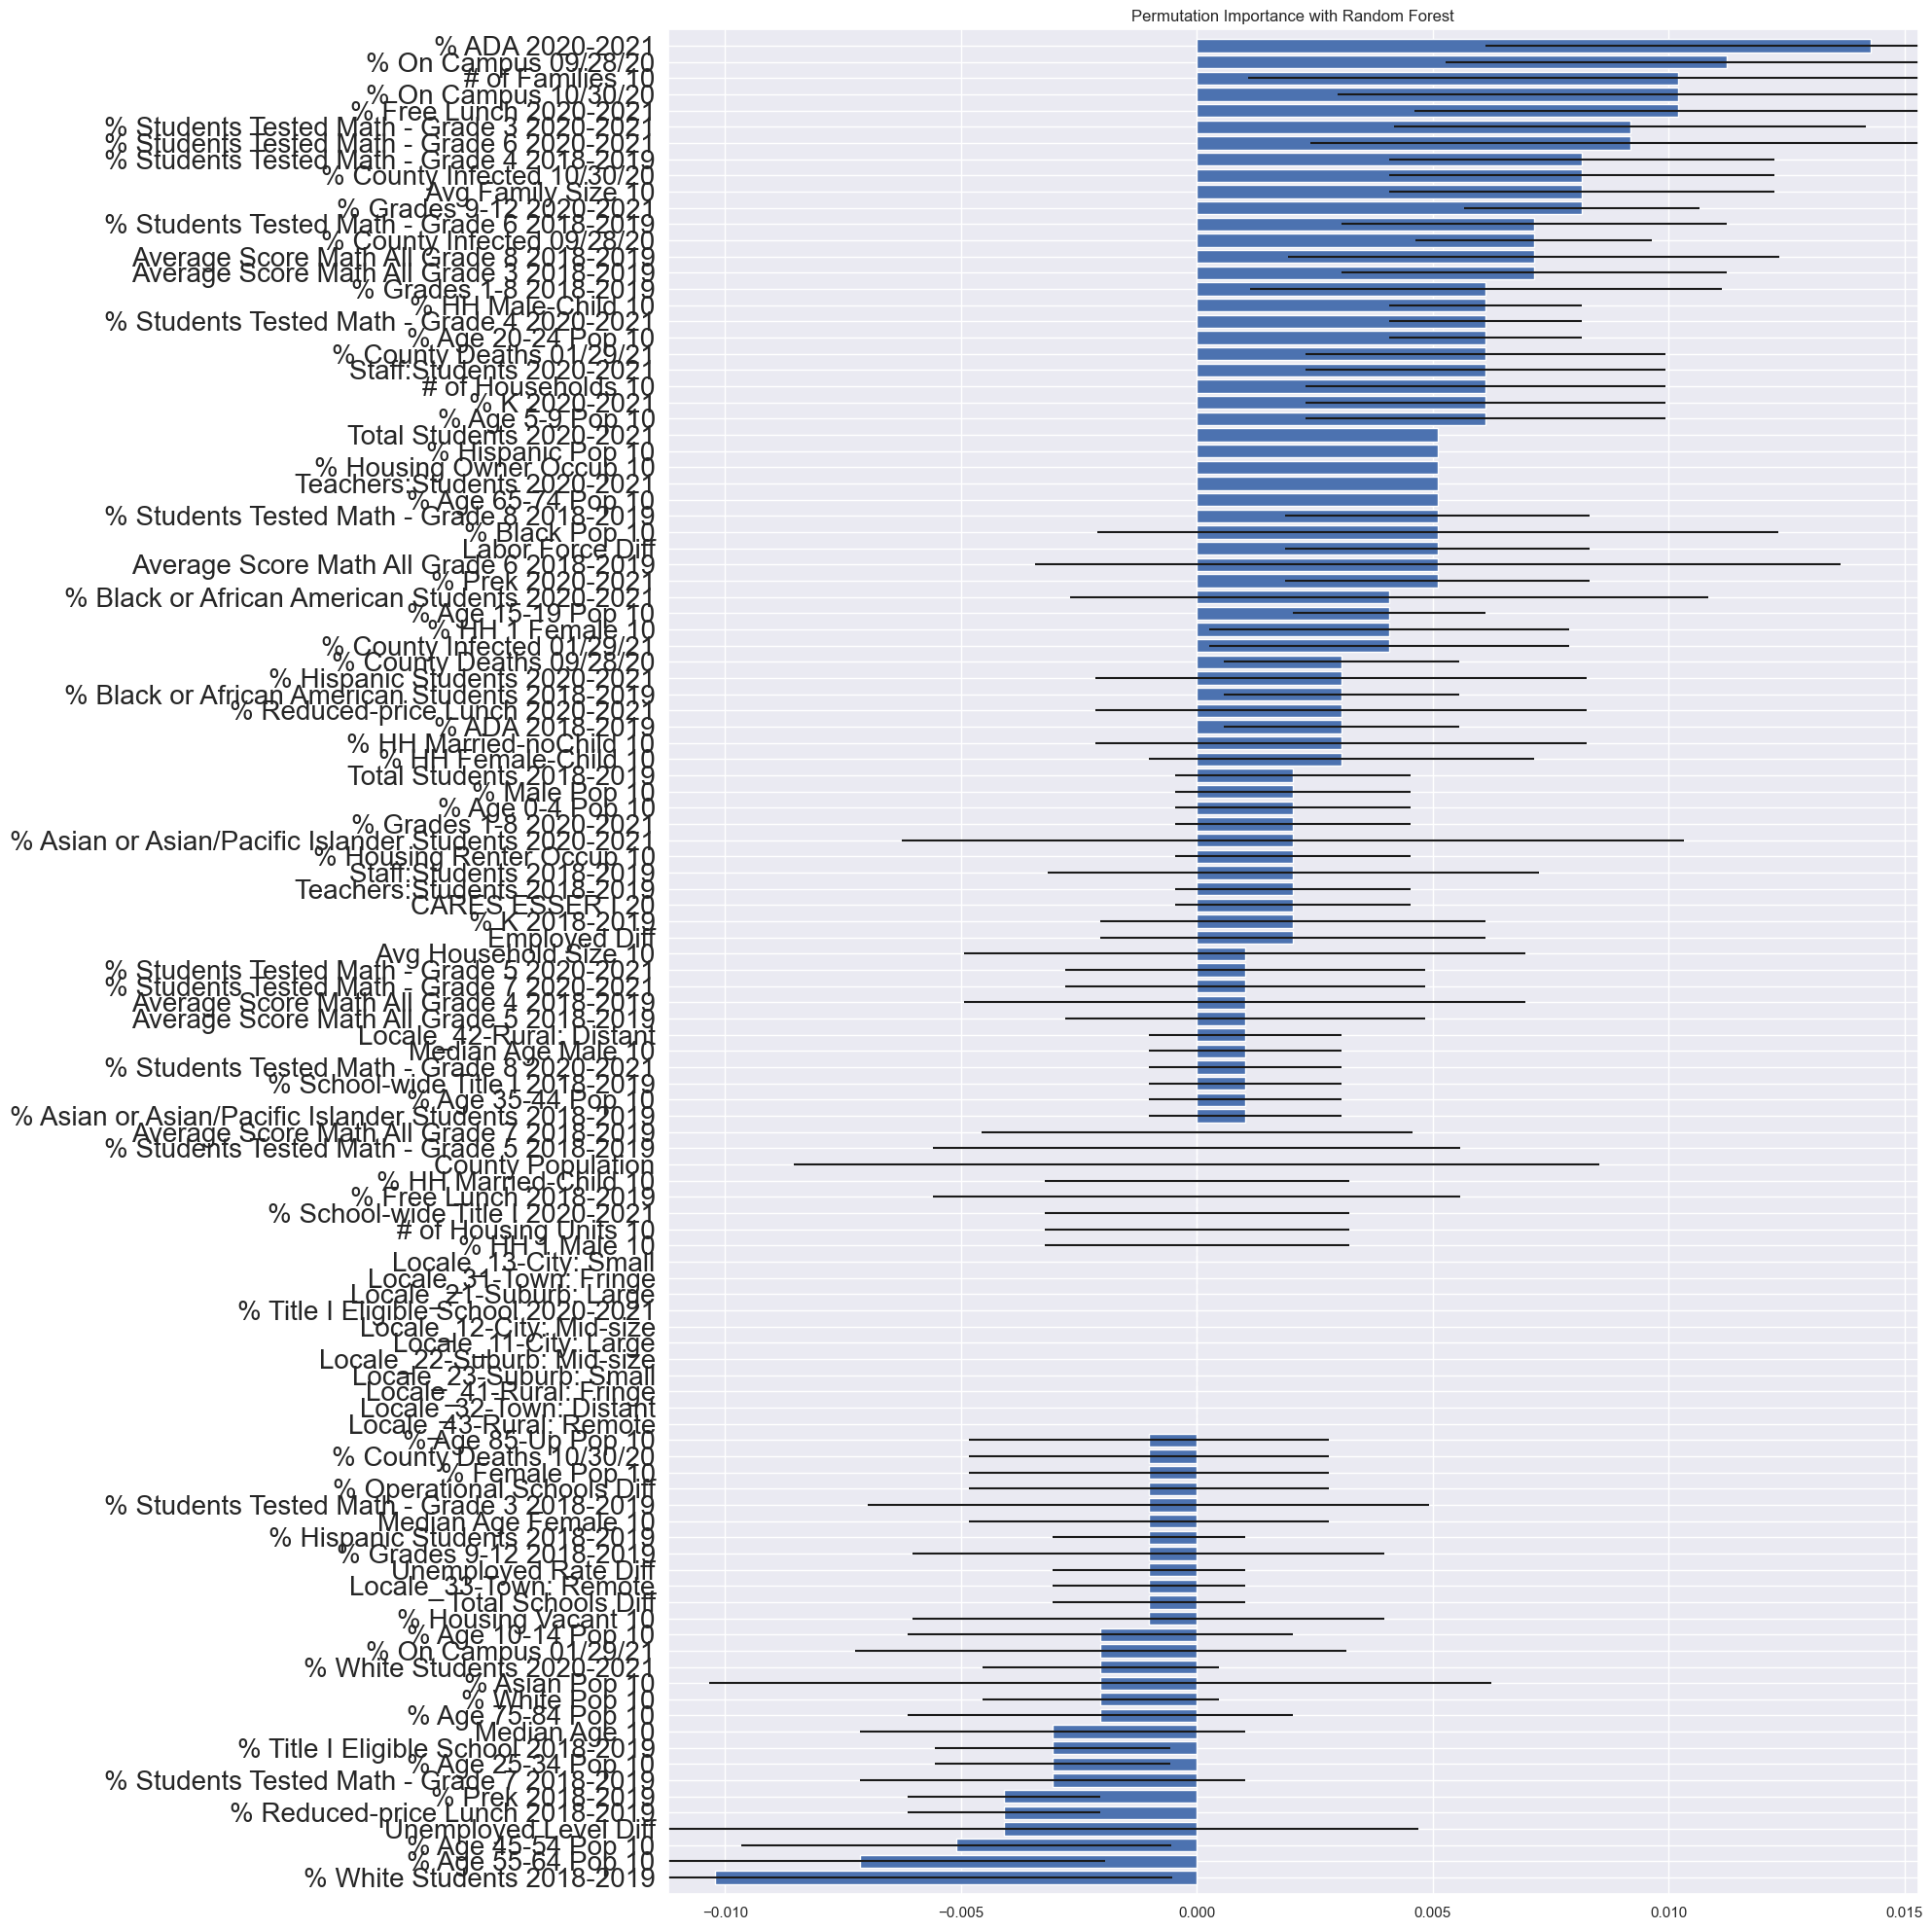

CPU times: user 2.41 s, sys: 362 ms, total: 2.77 s
Wall time: 4.96 s


In [12]:
%%time
from sklearn.inspection import permutation_importance

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

result = permutation_importance(estimator, X=X_test, y=y_test, scoring='accuracy', n_jobs=-1, random_state=random_state)
indices = np.argsort(result['importances_mean'])#[::-1]

plt.figure(figsize=(20,20))
plt.title("Permutation Importance with Random Forest")
plt.barh(range(X_train.shape[1]), result['importances_mean'][indices], xerr=result['importances_std'][indices])

plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.xlim([result['importances_mean'].min()-0.001, result['importances_mean'].max()+0.001])

plt.tight_layout()
plt.show()

temp = pd.DataFrame({'feature': columns, 
                     'method': 'Permutation Importance',
                     'model': 'Random Forest', 
                     'score': result['importances_mean'],
                     'score_type': 'importances_mean'})
results = pd.concat([results, temp], ignore_index=True)

### Permutation Importance ###
with Ridge Regression

Train Score: 0.72
Test Score: 0.69


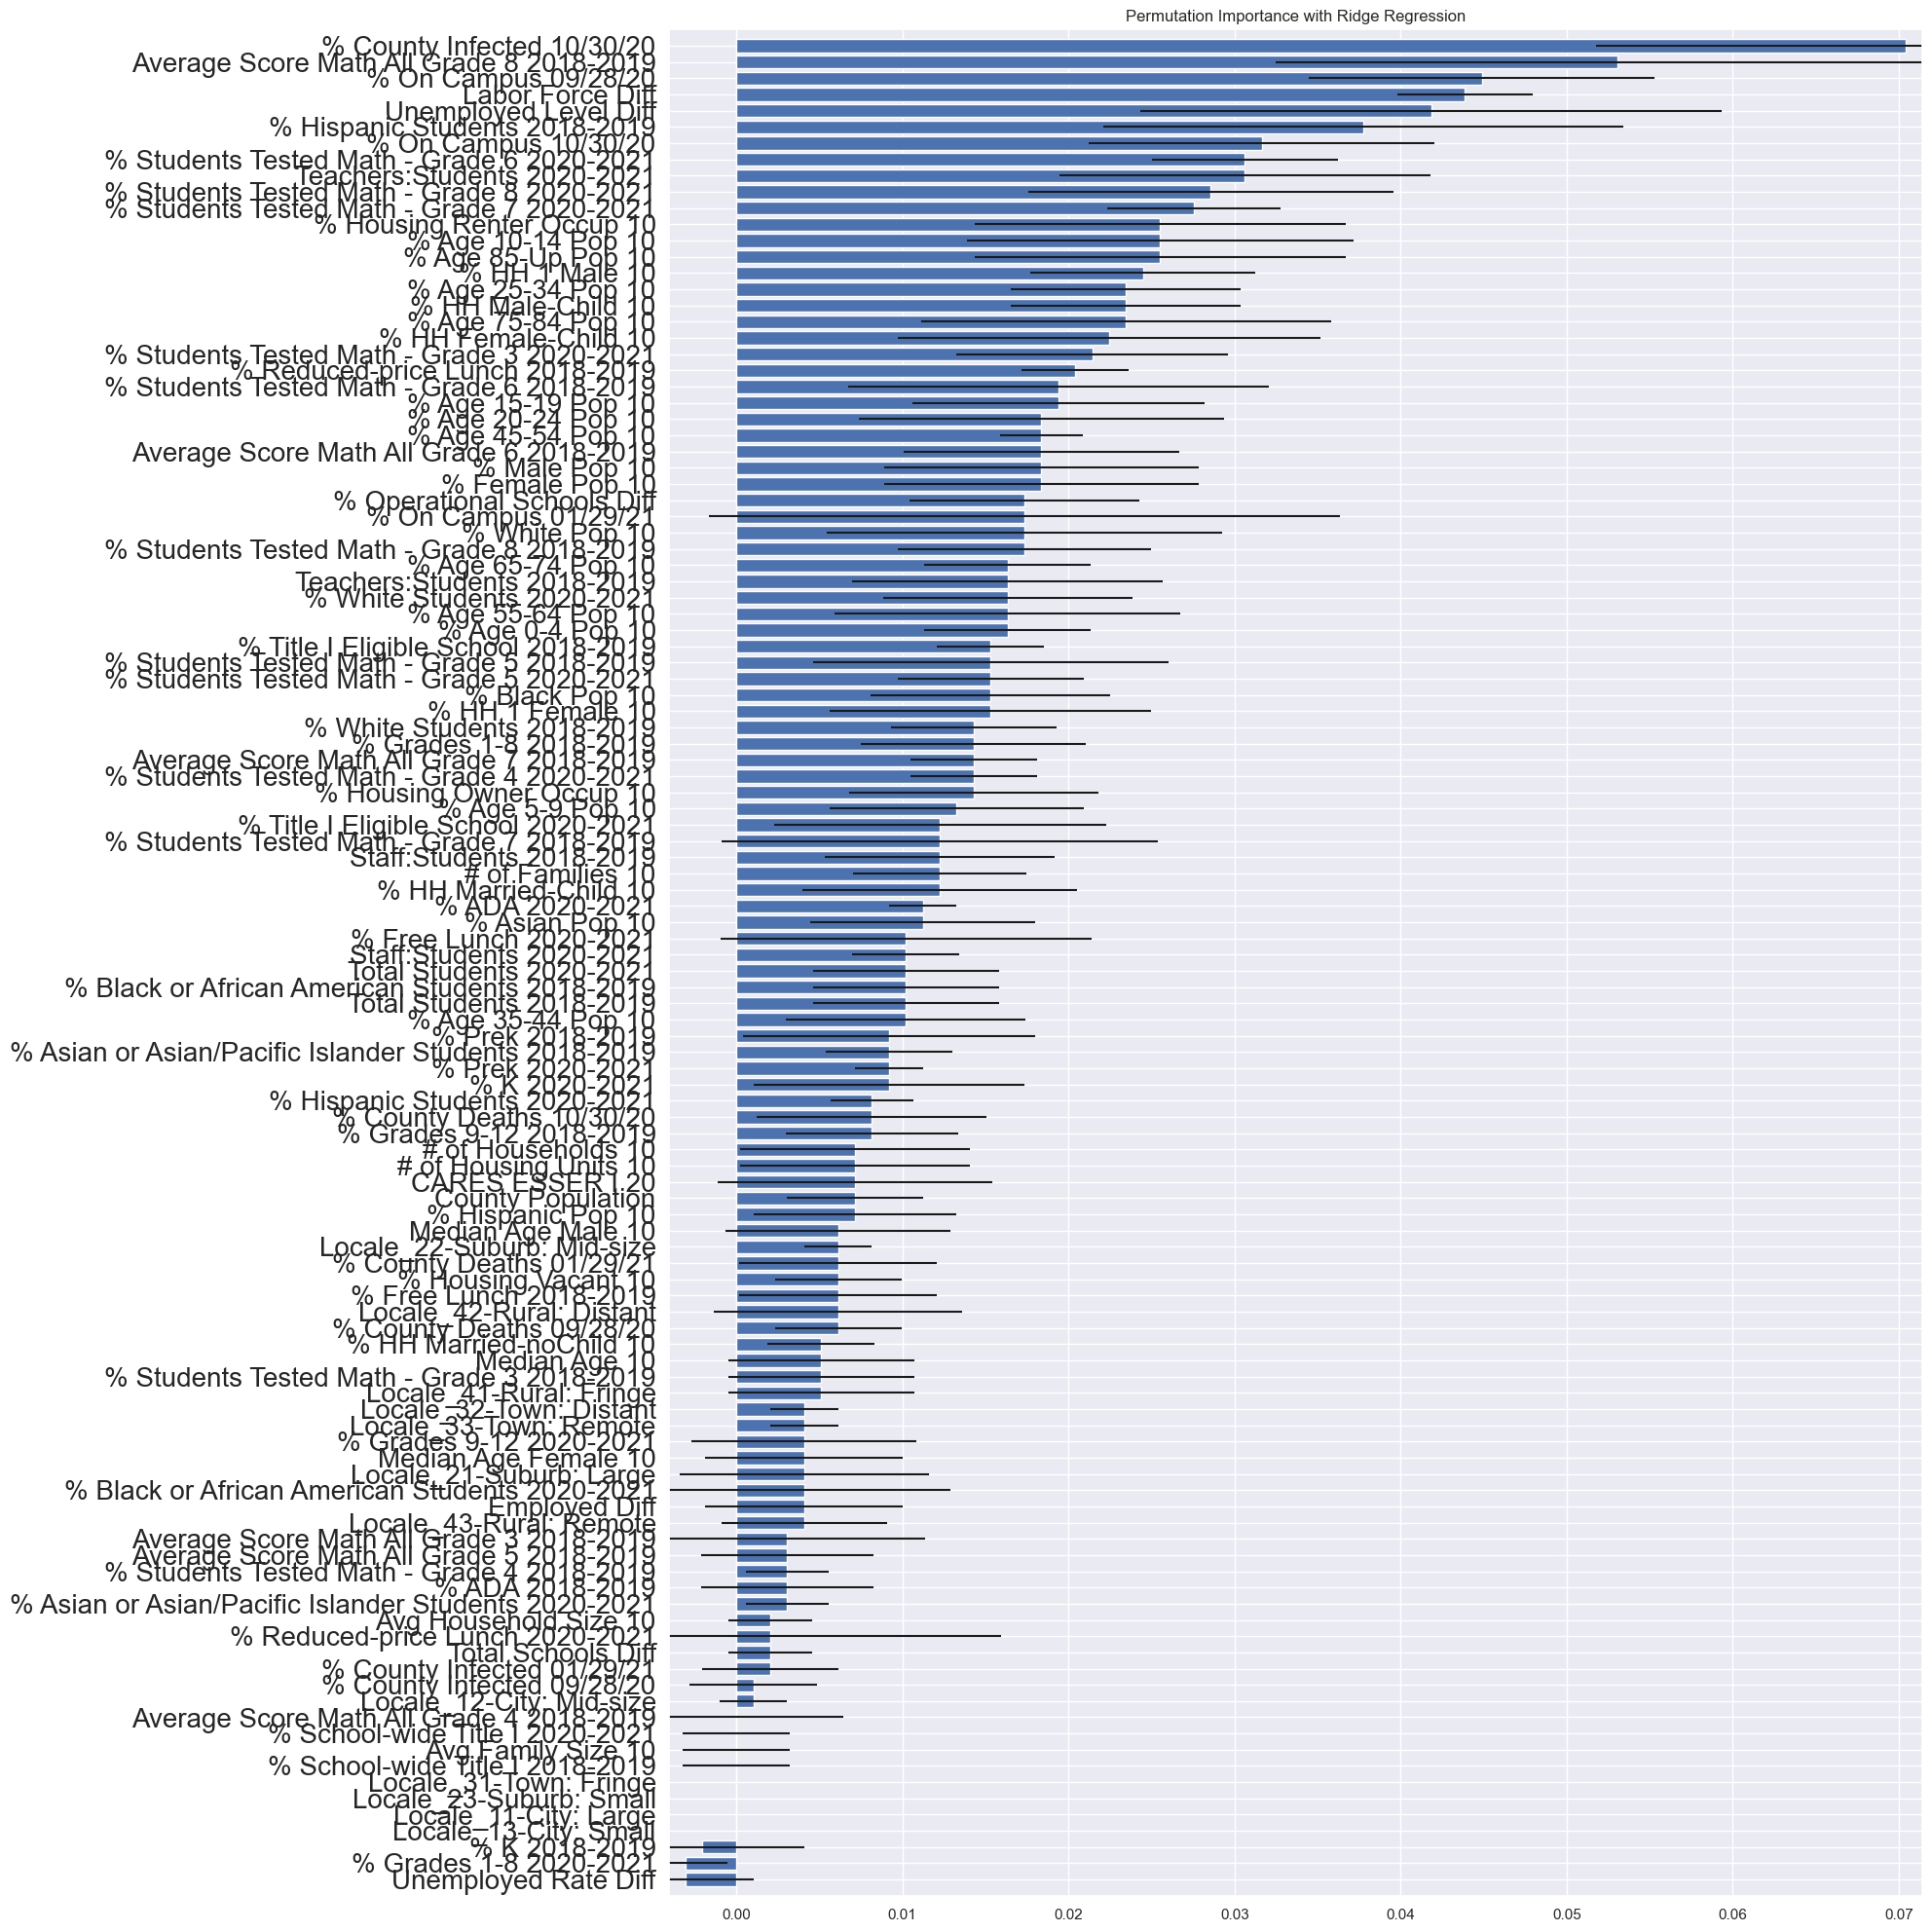

CPU times: user 1.2 s, sys: 229 ms, total: 1.43 s
Wall time: 897 ms


In [13]:
%%time
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

result = permutation_importance(estimator, X=X_test, y=y_test, scoring='accuracy', n_jobs=-1, random_state=random_state)
indices = np.argsort(result['importances_mean'])#[::-1]

plt.figure(figsize=(20,20))
plt.title("Permutation Importance with Ridge Regression")
plt.barh(range(X_train.shape[1]), result['importances_mean'][indices], xerr=result['importances_std'][indices])

plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.xlim([result['importances_mean'].min()-0.001, result['importances_mean'].max()+0.001])

plt.tight_layout()
plt.show()

temp = pd.DataFrame({'feature': columns, 
                     'method': 'Permutation Importance',
                     'model': 'Ridge', 
                     'score': result['importances_mean'],
                     'score_type': 'importances_mean'})
results = pd.concat([results, temp], ignore_index=True)

### Recursive Feature Elimination(RFE) ###
with Ridge Regression

In [14]:
%time
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr', random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

rfe = RFECV(estimator, step=1, cv=10, n_jobs=-1)
sel = rfe.fit(X_train, y_train)
support = sel.support_
n_sel = sel.n_features_

print('n Selected: ', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'RFE',
                     'model': 'Ridge', 
                     'score': rfe.ranking_,
                     'score_type': 'ranking'})
results = pd.concat([results, temp], ignore_index=True)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.1 µs
Train Score: 0.74
Test Score: 0.68
n Selected:  56
Selected Feature:  Index(['Total Students 2018-2019', 'Total Students 2020-2021',
       'Unemployed Level Diff', 'Median Age 10', 'Median Age Male 10',
       'Avg Household Size 10', '# of Families 10', 'Avg Family Size 10',
       'County Population', 'CARES ESSER I 20',
       '% School-wide Title I 2020-2021', '% School-wide Title I 2018-2019',
       '% Title I Eligible School 2020-2021',
       '% Title I Eligible School 2018-2019', 'Teachers:Students 2018-2019',
       'Staff:Students 2018-2019', '% Free Lunch 2020-2021',
       '% Asian or Asian/Pacific Islander Students 2020-2021',
       '% Asian or Asian/Pacific Islander Students 2018-2019',
       '% Hispanic Students 2018-2019',
       '% Black or African American Students 2020-2021',
       '% Black or African American Students 2018-2019',
       '% White Students 2020-2021', '% Grades 9-12 2020-2021',
  

### Recursive Feature Elimination(RFE) ###
with Random Forest

In [15]:
%time
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

rfe = RFECV(estimator, step=1, cv=5, n_jobs=-1)
sel = rfe.fit(X_train, y_train)
support = sel.support_
n_sel = sel.n_features_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'RFE',
                     'model': 'Random Forest', 
                     'score': rfe.ranking_,
                     'score_type': 'ranking'})
results = pd.concat([results, temp], ignore_index=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Train Score: 1.00
Test Score: 0.68
n Selected: 57
Selected Feature:  Index(['Total Students 2018-2019', 'Total Students 2020-2021',
       'Labor Force Diff', 'Employed Diff', 'Unemployed Level Diff',
       '# of Households 10', 'Avg Household Size 10', '# of Families 10',
       'Avg Family Size 10', 'County Population', 'CARES ESSER I 20',
       'Teachers:Students 2020-2021', 'Teachers:Students 2018-2019',
       'Staff:Students 2020-2021', 'Staff:Students 2018-2019',
       '% Free Lunch 2020-2021', '% Free Lunch 2018-2019',
       '% Asian or Asian/Pacific Islander Students 2020-2021',
       '% Hispanic Students 2020-2021', '% Hispanic Students 2018-2019',
       '% Black or African American Students 2020-2021',
       '% Black or African American Students 2018-2019',
       '% White Students 2020-2021', '% White Students 2018-2019',
       '% Grades 1-8 2020-2021', '% Grades 1-8 2018-2019',
       '% Grades 9-12 20

### Sequential Feature Selection(SFS) ###
with KNN

In [16]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(n_neighbors=3)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

sfs = SequentialFeatureSelector(estimator, n_jobs=-1, n_features_to_select='auto', tol=None)
sfs.fit(X_train, y_train)

support = sfs.get_support()
n_sel = sfs.n_features_to_select_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'SFS',
                     'model': 'KNN', 
                     'score': [1 if ft in columns[support] else 0 for ft in columns],
                     'score_type': 'N/A'})
results = pd.concat([results, temp], ignore_index=True)

Train Score: 0.77
Test Score: 0.63
n Selected: 57
Selected Feature:  Index(['Total Students 2018-2019', 'Total Students 2020-2021', 'Employed Diff',
       'Median Age 10', 'Median Age Male 10', 'Median Age Female 10',
       '# of Households 10', 'Avg Household Size 10', '# of Families 10',
       'Avg Family Size 10', '# of Housing Units 10', 'County Population',
       'CARES ESSER I 20', '% School-wide Title I 2018-2019',
       '% Title I Eligible School 2020-2021',
       '% Title I Eligible School 2018-2019', 'Teachers:Students 2018-2019',
       'Staff:Students 2018-2019', '% Free Lunch 2020-2021',
       '% Free Lunch 2018-2019', '% Reduced-price Lunch 2020-2021',
       '% Asian or Asian/Pacific Islander Students 2020-2021',
       '% Asian or Asian/Pacific Islander Students 2018-2019',
       '% Hispanic Students 2020-2021', '% Hispanic Students 2018-2019',
       '% Black or African American Students 2020-2021',
       '% Black or African American Students 2018-2019',
     

### Sequential Feature Selection(SFS) ###
with Ridge Regression

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

sfs = SequentialFeatureSelector(estimator, n_jobs=-1, n_features_to_select='auto', tol=None)
sfs.fit(X_train, y_train)

support = sfs.get_support()
n_sel = sfs.n_features_to_select_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'SFS',
                     'model': 'Ridge', 
                     'score': [1 if ft in columns[support] else 0 for ft in columns],
                     'score_type': 'N/A'})
results = pd.concat([results, temp], ignore_index=True)

Train Score: 0.72
Test Score: 0.69
n Selected: 57
Selected Feature:  Index(['Total Students 2018-2019', 'Total Students 2020-2021',
       'CARES ESSER I 20', 'Teachers:Students 2020-2021',
       'Teachers:Students 2018-2019', 'Staff:Students 2020-2021',
       'Staff:Students 2018-2019', '% Free Lunch 2018-2019',
       '% Reduced-price Lunch 2020-2021', '% Reduced-price Lunch 2018-2019',
       '% Asian or Asian/Pacific Islander Students 2020-2021',
       '% Asian or Asian/Pacific Islander Students 2018-2019',
       '% Hispanic Students 2020-2021', '% Hispanic Students 2018-2019',
       '% White Students 2018-2019', '% Grades 1-8 2020-2021',
       '% Grades 1-8 2018-2019', '% Grades 9-12 2020-2021',
       '% Grades 9-12 2018-2019', '% Prek 2020-2021', '% K 2020-2021',
       '% ADA 2018-2019', '% ADA 2020-2021',
       '% Students Tested Math - Grade 3 2018-2019',
       '% Students Tested Math - Grade 4 2018-2019',
       '% Students Tested Math - Grade 5 2018-2019',
       '%

### Result: Number of Feature Selected ###

In [18]:
results['selected'] = results['score'].apply(lambda x: 1 if x > 0 else 0)

th_quantile=0.5
th_rf = results[results['method'] == 'Feature Importance']['score'].quantile(th_quantile)
print('Threshold for Random Forest Feature Importance is {:0.4f} at {:0.0f}th percentile'.format(th_rf, th_quantile*100))
results['selected'] = results.apply(lambda x: 0 if ((x.method == 'Feature Importance') & (x.score < th_rf))
                                                 else x.selected, axis=1)
results['selected'] = results.apply(lambda x: 0 if ((x.method == 'RFE') & (x.score > 1))
                                                 else x.selected, axis=1)
results['selected'] = results.apply(lambda x: 1 if ((x.method == 'Regularization') & (x.score != 0))
                                                 else x.selected, axis=1)
              
results['Method'] = results.apply(lambda x: 'Variance Threshold' if x.method == 'Variance Threshold'
                                                                 else str(x.method) + " - " + str(x.model), axis=1)

Threshold for Random Forest Feature Importance is 0.0076 at 50th percentile


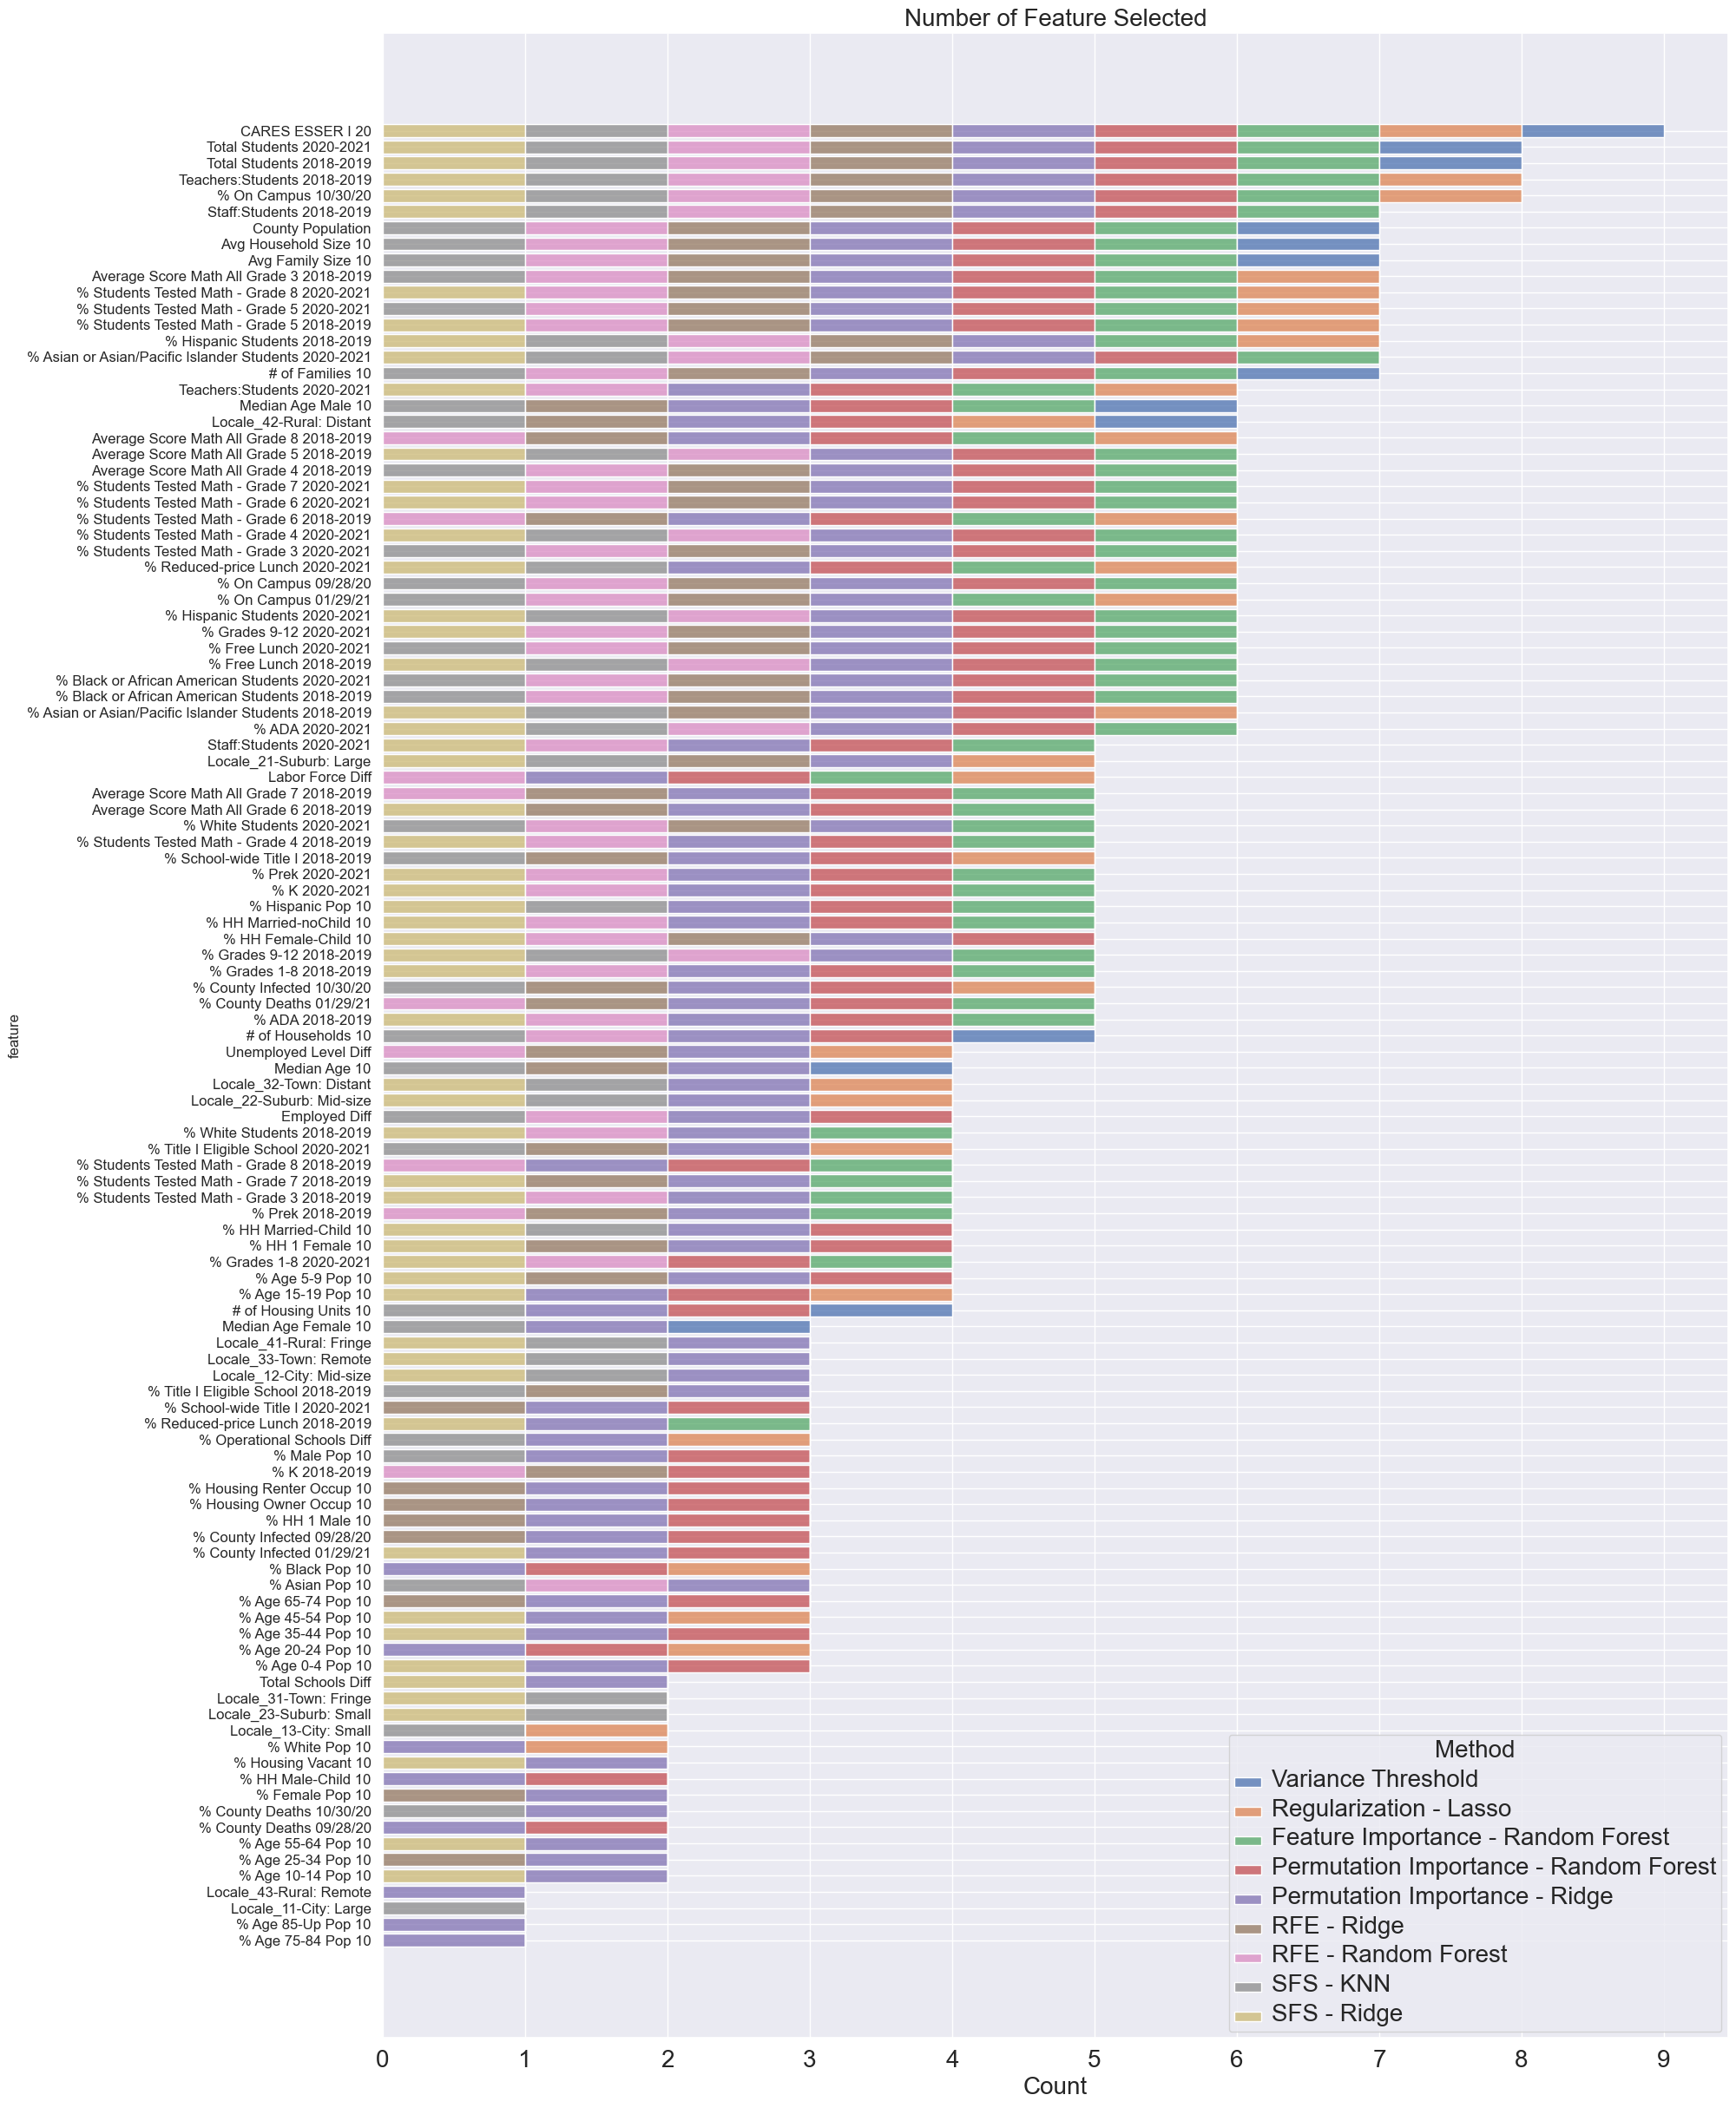

In [19]:
sns.set(rc={'figure.figsize':(20,30)})

features_selected = results[results['selected'] == 1].copy()
features_selected['counts']=features_selected.groupby('feature').transform(lambda x: x.sum())['selected']
features_selected = features_selected.sort_values(by=['counts', 'feature'], ascending=False)

g = sns.histplot(data=features_selected, y='feature', hue='Method', multiple='stack', shrink=0.8, legend=True)
plt.title('Number of Feature Selected', size=20)
plt.xlabel('Count', size=20)
plt.xticks(range(len(features_selected['Method'].unique())+1), list(range(len(features_selected['Method'].unique())+1)), size=20)
plt.yticks(range(len(features_selected.feature.unique())), features_selected.feature.unique(), size=12)
# plt.legend(fontsize=20)
plt.setp(g.get_legend().get_texts(), fontsize='20')
plt.setp(g.get_legend().get_title(), fontsize='20') 
plt.show()

In [20]:
features_selected2 = features_selected.groupby(['feature'], as_index=False).agg({'counts': 'count'})
features_selected2 = features_selected2.sort_values(by=['counts'], ascending=False)
print("Most importance features selected:")
features_selected2[:32]

Most importance features selected:


feature  counts
86                                    CARES ESSER I 20       9
111                           Total Students 2020-2021       8
110                           Total Students 2018-2019       8
53                                % On Campus 10/30/20       8
107                        Teachers:Students 2018-2019       8
0                                     # of Families 10       7
72          % Students Tested Math - Grade 8 2020-2021       7
66          % Students Tested Math - Grade 5 2020-2021       7
19   % Asian or Asian/Pacific Islander Students 202...       7
65          % Students Tested Math - Grade 5 2018-2019       7
84                                  Avg Family Size 10       7
85                               Avg Household Size 10       7
87                                   County Population       7
43                       % Hispanic Students 2018-2019       7
105                           Staff:Students 2018-2019       7
78            Average Score Math All Grade 3 2018-2019       7
64          % Students Tested Math - Grade 4 2020-2021       6
62          % Students Tested Math - Grade 3 2020-2021       6
58                     % Reduced-price Lunch 2020-2021       6
35                             % Grades 9-12 2020-2021       6
44                       % Hispanic Students 2020-2021       6
52                                % On Campus 09/28/20       6
67          % Students Tested Math - Grade 6 2018-2019       6
68          % Students Tested Math - Grade 6 2020-2021       6
31                              % Free Lunch 2020-2021       6
30                              % Free Lunch 2018-2019       6
70          % Students Tested Math - Grade 7 2020-2021       6
80            Average Score Math All Grade 5 2018-2019       6
51                                % On Campus 01/29/21       6
100                           Locale_42-Rural: Distant       6
4                                      % ADA 2020-2021       6
108                        Teachers:Students 2020-2021       6

In [21]:
results.to_csv('Feature_Selection_Math_Results.csv', index=False)
results

feature              method  model  score score_type  \
0     Total Students 2018-2019  Variance Threshold    N/A    1.0        N/A   
1     Total Students 2020-2021  Variance Threshold    N/A    1.0        N/A   
2             Labor Force Diff  Variance Threshold    N/A    0.0        N/A   
3                Employed Diff  Variance Threshold    N/A    0.0        N/A   
4        Unemployed Level Diff  Variance Threshold    N/A    0.0        N/A   
...                        ...                 ...    ...    ...        ...   
1021   Locale_32-Town: Distant                 SFS  Ridge    1.0        N/A   
1022    Locale_33-Town: Remote                 SFS  Ridge    1.0        N/A   
1023   Locale_41-Rural: Fringe                 SFS  Ridge    1.0        N/A   
1024  Locale_42-Rural: Distant                 SFS  Ridge    0.0        N/A   
1025   Locale_43-Rural: Remote                 SFS  Ridge    0.0        N/A   

      selected              Method  
0            1  Variance Threshold  
1            1  Variance Threshold  
2            0  Variance Threshold  
3            0  Variance Threshold  
4            0  Variance Threshold  
...        ...                 ...  
1021         1         SFS - Ridge  
1022         1         SFS - Ridge  
1023         1         SFS - Ridge  
1024         0         SFS - Ridge  
1025         0         SFS - Ridge  

[1026 rows x 7 columns]

In [22]:
importance=results.pivot(index="feature", columns="Method", values="score").reset_index()
importance.to_csv('importance_math.csv', index=False)
importance

Method                   feature  Feature Importance - Random Forest  \
0               # of Families 10                            0.009446   
1             # of Households 10                            0.007460   
2          # of Housing Units 10                            0.005688   
3                % ADA 2018-2019                            0.010400   
4                % ADA 2020-2021                            0.013501   
..                           ...                                 ...   
109           Total Schools Diff                            0.001971   
110     Total Students 2018-2019                            0.011788   
111     Total Students 2020-2021                            0.012598   
112        Unemployed Level Diff                            0.007047   
113         Unemployed Rate Diff                            0.005270   

Method  Permutation Importance - Random Forest  \
0                                 1.020408e-02   
1                                 6.122449e-03   
2                                 2.220446e-17   
3                                 3.061224e-03   
4                                 1.428571e-02   
..                                         ...   
109                              -1.020408e-03   
110                               2.040816e-03   
111                               5.102041e-03   
112                              -4.081633e-03   
113                              -1.020408e-03   

Method  Permutation Importance - Ridge  RFE - Random Forest  RFE - Ridge  \
0                             0.012245                  1.0          1.0   
1                             0.007143                  1.0         45.0   
2                             0.007143                 14.0         31.0   
3                             0.003061                  1.0         22.0   
4                             0.011224                  1.0         54.0   
..                                 ...                  ...          ...   
109                           0.002041                 46.0         40.0   
110                           0.010204                  1.0          1.0   
111                           0.010204                  1.0          1.0   
112                           0.041837                  1.0          1.0   
113                          -0.003061                 27.0         13.0   

Method  Regularization - Lasso  SFS - KNN  SFS - Ridge  Variance Threshold  
0                      0.00000        1.0          0.0                 1.0  
1                      0.00000        1.0          0.0                 1.0  
2                      0.00000        1.0          0.0                 1.0  
3                      0.00000        0.0          1.0                 0.0  
4                      0.00000        1.0          1.0                 0.0  
..                         ...        ...          ...                 ...  
109                    0.00000        0.0          1.0                 0.0  
110                    0.00000        1.0          1.0                 1.0  
111                    0.00000        1.0          1.0                 1.0  
112                    0.20267        0.0          0.0                 0.0  
113                    0.00000        0.0          0.0                 0.0  

[114 rows x 10 columns]

## Regression coefficients

### Logistic Regression - Ridge ###

In [23]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)

print('Train Accuracy: {:0.2f}'.format(estimator.score(X_train, y_train)))
print('Test Accuracy: {:0.2f}'.format(estimator.score(X_test, y_test)))


classes = ['Loss', 'Expected', 'Gain']
for coef, cl in zip(estimator.coef_, classes):
    temp = pd.DataFrame({'feature': columns,
                         'model': 'Ridge',
                         'coef': coef, 
                         'label': cl})
    results_coef = pd.concat([results_coef, temp], ignore_index=True)

Train Accuracy: 0.72
Test Accuracy: 0.69


### Logistic Regression - ElasticNet ###

In [24]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='elasticnet', solver='saga', multi_class='ovr', C=0.1, random_state=random_state,
                              l1_ratio=.5, max_iter=10000)
estimator.fit(X_train, y_train)

print('Train Accuracy: {:0.2f}'.format(estimator.score(X_train, y_train)))
print('Test Accuracy: {:0.2f}'.format(estimator.score(X_test, y_test)))


classes = ['Loss', 'Expected', 'Gain']
for coef, cl in zip(estimator.coef_, classes):
    temp = pd.DataFrame({'feature': columns,
                         'model': 'ElasticNet',
                         'coef': coef, 
                         'label': cl})
    results_coef = pd.concat([results_coef, temp], ignore_index=True)

Train Accuracy: 0.70
Test Accuracy: 0.64


In [26]:
coef = results_coef.pivot(index="feature", columns=["model", "label"], values="coef").reset_index()
coef.to_csv('coef_math.csv', index=False)
coef

model                   feature     Lasso                        Ridge  \
label                                Loss Expected      Gain      Loss   
0              # of Families 10  0.000000  0.00000  0.000000 -0.048387   
1            # of Households 10  0.000000  0.00000  0.000000 -0.011630   
2         # of Housing Units 10  0.000000  0.00000  0.000000 -0.016754   
3               % ADA 2018-2019 -0.000893  0.00000  0.000000 -0.131181   
4               % ADA 2020-2021  0.000000  0.00000  0.000000  0.059456   
..                          ...       ...      ...       ...       ...   
109          Total Schools Diff  0.000000  0.00000  0.000000  0.074892   
110    Total Students 2018-2019  0.000000  0.00000  0.000000 -0.090579   
111    Total Students 2020-2021  0.000000  0.00000  0.000000 -0.106779   
112       Unemployed Level Diff -0.169442  0.20267  0.000000 -0.262361   
113        Unemployed Rate Diff  0.000000  0.00000 -0.021871  0.053907   

model                     ElasticNet                      
label  Expected      Gain       Loss  Expected      Gain  
0      0.067214 -0.040485   0.000000  0.000000  0.000000  
1      0.025757 -0.039098   0.000000  0.000000  0.000000  
2      0.026709 -0.037968   0.000000  0.000000  0.000000  
3      0.099866 -0.005764  -0.067556  0.023523  0.000000  
4     -0.058065  0.025182   0.000000 -0.007027  0.000000  
..          ...       ...        ...       ...       ...  
109    0.033313 -0.070740   0.000000  0.006678 -0.029093  
110    0.108492 -0.098665   0.000000  0.000000 -0.033452  
111    0.134500 -0.093430   0.000000  0.036496 -0.014744  
112    0.393518 -0.181374  -0.198261  0.291495  0.000000  
113   -0.040743 -0.031154   0.003535  0.000000 -0.063693  

[114 rows x 10 columns]